# Оценка потребляемой мощности для Top 500 суперкомпьютеров в мире на 2021 год

In [47]:
import pathlib
import warnings

import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from supervised.automl import AutoML
from sklearn.preprocessing import FunctionTransformer

%matplotlib inline

mpl.rcParams["figure.figsize"] = (8, 8)
mpl.rcParams["figure.dpi"] = 100
plt.style.use('seaborn')

In [48]:
%load_ext autoreload
%autoreload 2

from notebook_utils import comma_number2str, twatt2kwatt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
data_path = pathlib.Path("data", "raw")

Для оценки мощности нужна знать эти значения для всех суперкомпьютеров. К сожалению, нужная информация доступна лишь только для части суперкомпьютеров. Для остальных она недоступна. Чтобы как-то оценить общую суммарную потребляемую мощность необходимо заполнить пропущенные значения. Попробуем построить ML модель, которая предскажет пропущенные значения на основе уже известных данных по потребляемой мощности.

Для этого возьмём [данные за 2020-2021 год](https://www.top500.org/lists/top500/), чтобы расширить набор данных для обучения. 

На основе EDA этого были выбраны столбцы, которые имеет смысл анализировать и несут полезную информацию для предсказаний.

In [50]:
ALL_COLUMNS = frozenset(("Rank", "Previous Rank", "First Appearance", "First Rank", "Name", "Computer", "Site", "Manufacturer",
                         "Country", "Year", "Segment", "Total Cores", "Accelerator/Co-Processor Cores", "Rmax [TFlop/s]", "Rpeak [TFlop/s]", "Nmax",
                         "Nhalf", "HPCG [TFlop/s]", "Power (kW)", "Power Source", "Power Efficiency [GFlops/Watts]", "Memory", "Architecture",
                         "Processor", "Processor Technology", "Processor Speed (MHz)", "Operating System", "OS Family", "Accelerator/Co-Processor",
                         "Cores per Socket", "Processor Generation", "System Model", "System Family", "Interconnect Family", "Interconnect",
                         "Continent", "Site ID", "System ID"))


In [51]:
DROP_COLUMNS = frozenset((
    "Previous Rank", "First Rank", "First Appearance", "Power Source", "Memory", "OS Family", "Name", "Computer", "Site",
    "HPCG [TFlop/s]", "System Model", "Site ID", "System ID", "Accelerator/Co-Processor Cores", "Nhalf", "Power Efficiency [GFlops/Watts]"
))


In [52]:
SELECTED_COLUMNS = ALL_COLUMNS.difference(DROP_COLUMNS)

In [53]:
TARGET_COLUMN_NAME = "Power (kW)"


In [54]:
NUMERIC_COLUMNS = ("Total Cores", "Accelerator/Co-Processor Cores", "Rmax [TFlop/s]",
                   "Rpeak [TFlop/s]", "Nmax", "Total Cores", "Processor Speed (MHz)", "Power (kW)")
CATEGORY_COLUMNS = ("Manufacturer", "Country", "Segment", "Architecture", "Processor", "Processor Technology",
                    "Operating System", "Accelerator/Co-Processor", "Processor Generation", "System Family", "Interconnect Family", "Interconnect", "Continent")
FILEINDEX_COL = "file_index_year"

In [55]:
assert FILEINDEX_COL not in SELECTED_COLUMNS

In [56]:
all_data = pd.DataFrame()

for path in data_path.glob("TOP500_*.csv"):
    file_index = path.stem.split("_")[1]
    data = pd.read_csv(path, engine="c", usecols=SELECTED_COLUMNS,
                       converters={col_name: comma_number2str for col_name in NUMERIC_COLUMNS},
                       encoding="utf-8",
                       dtype={col_name: "category" for col_name in CATEGORY_COLUMNS})
    data[FILEINDEX_COL] = file_index
    all_data = all_data.append(data, ignore_index=True)

del data


In [57]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Rank                      1500 non-null   int64   
 1   Manufacturer              1500 non-null   object  
 2   Country                   1500 non-null   object  
 3   Year                      1500 non-null   int64   
 4   Segment                   1500 non-null   category
 5   Total Cores               1500 non-null   int64   
 6   Rmax [TFlop/s]            1500 non-null   float64 
 7   Rpeak [TFlop/s]           1500 non-null   float64 
 8   Nmax                      1482 non-null   float64 
 9   Power (kW)                576 non-null    float64 
 10  Architecture              1500 non-null   category
 11  Processor                 1500 non-null   object  
 12  Processor Technology      1500 non-null   object  
 13  Processor Speed (MHz)     1500 non-null   int64 

In [58]:
all_data.describe()

,Rank,Year,Total Cores,Rmax [TFlop/s],Rpeak [TFlop/s],Nmax,Power (kW),Processor Speed (MHz),Cores per Socket
count,1500.000000,1500.000000,1.500000e+03,1500.000000,1500.000000,1.482000e+03,576.000000,1500.000000,1500.000000
mean,250.500000,2018.270667,1.470297e+05,4947.303367,7819.322433,5.016004e+06,1762.531719,2386.858667,22.086667
std,144.385415,1.629471,6.438063e+05,21731.160694,27670.142820,2.804851e+06,3253.643223,316.451595,16.209122
min,1.000000,2010.000000,1.664000e+03,1228.000000,181.300000,4.870000e+05,61.360000,1300.000000,4.000000
25%,125.750000,2018.000000,4.732000e+04,1649.110000,2465.525000,2.741752e+06,555.595000,2250.000000,16.000000
50%,250.500000,2018.000000,5.760000e+04,1976.000000,3744.000000,4.800000e+06,887.000000,2300.000000,20.000000
75%,375.250000,2019.000000,8.720000e+04,2779.840000,5184.000000,7.171008e+06,1468.500000,2500.000000,20.000000
max,500.000000,2021.000000,1.064960e+07,442010.000000,537212.000000,2.128896e+07,29899.230000,3836.000000,260.000000


In [59]:
all_data.head(n=3)

,Rank,Manufacturer,Country,Year,Segment,Total Cores,Rmax [TFlop/s],Rpeak [TFlop/s],Nmax,Power (kW),...,Processor Speed (MHz),Operating System,Accelerator/Co-Processor,Cores per Socket,Processor Generation,System Family,Interconnect Family,Interconnect,Continent,file_index_year
0,1,Fujitsu,Japan,2020,Research,7299072,415530.0,513854.67,20459520.0,28334.50,...,2200,Red Hat Enterprise Linux,None,48,Fujitsu A64FX,Fujitsu Cluster,Proprietary Network,Tofu interconnect D,Asia,202006
1,2,IBM,United States,2018,Research,2414592,148600.0,200794.88,16473600.0,10096.00,...,3070,RHEL 7.4,NVIDIA Volta GV100,22,IBM POWER9,IBM Power Systems,Infiniband,Dual-rail Mellanox EDR Infiniband,North America,202006
2,3,IBM / NVIDIA / Mellanox,United States,2018,Research,1572480,94640.0,125712.00,11902464.0,7438.28,...,3100,Red Hat Enterprise Linux,NVIDIA Volta GV100,22,IBM POWER9,IBM Power Systems,Infiniband,Dual-rail Mellanox EDR Infiniband,North America,202006


## Предобработка данных

In [60]:
features, target = all_data[all_data.columns.drop([TARGET_COLUMN_NAME, "Rank", FILEINDEX_COL])], all_data[TARGET_COLUMN_NAME]

In [61]:
train_features = features[target.notna()]
test_features = features[target.isna()]
train_target = target[target.notna()]

In [62]:
train_features = train_features.drop_duplicates()
train_target = train_target.loc[train_features.index]

In [63]:
assert len(train_features) == len(train_target)

In [64]:
train_features.head(n=3)

,Manufacturer,Country,Year,Segment,Total Cores,Rmax [TFlop/s],Rpeak [TFlop/s],Nmax,Architecture,Processor,Processor Technology,Processor Speed (MHz),Operating System,Accelerator/Co-Processor,Cores per Socket,Processor Generation,System Family,Interconnect Family,Interconnect,Continent
0,Fujitsu,Japan,2020,Research,7299072,415530.0,513854.67,20459520.0,MPP,A64FX 48C 2.2GHz,Fujitsu ARM,2200,Red Hat Enterprise Linux,None,48,Fujitsu A64FX,Fujitsu Cluster,Proprietary Network,Tofu interconnect D,Asia
1,IBM,United States,2018,Research,2414592,148600.0,200794.88,16473600.0,Cluster,IBM POWER9 22C 3.07GHz,Power,3070,RHEL 7.4,NVIDIA Volta GV100,22,IBM POWER9,IBM Power Systems,Infiniband,Dual-rail Mellanox EDR Infiniband,North America
2,IBM / NVIDIA / Mellanox,United States,2018,Research,1572480,94640.0,125712.00,11902464.0,Cluster,IBM POWER9 22C 3.1GHz,Power,3100,Red Hat Enterprise Linux,NVIDIA Volta GV100,22,IBM POWER9,IBM Power Systems,Infiniband,Dual-rail Mellanox EDR Infiniband,North America


In [65]:
len(train_target)

267

## Визуализация целевой переменной 

<AxesSubplot:>

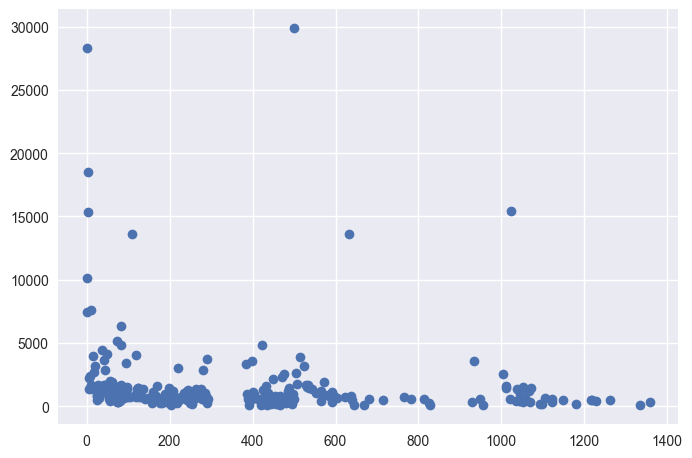

In [66]:
train_target.plot(style="o")

In [67]:
log_transform = FunctionTransformer(func=np.log, inverse_func=np.exp)

<AxesSubplot:>

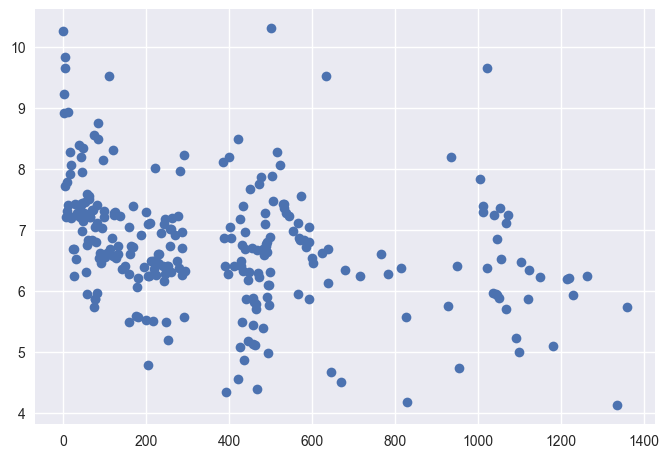

In [68]:
log_transform.fit_transform(train_target).plot(style="o")

## Построение модели

Для построения модели воспользуемся AutoML.

In [69]:
transformed_train_target = log_transform.fit_transform(train_target)

In [70]:
auto_ml = AutoML(mode="Perform", ml_task="regression", algorithms=["Decision Tree", "Random Forest", "Nearest Neighbors"], \
     eval_metric="mae", validation_strategy={"validation_type": "kfold", "k_folds": 3, "stratify": False}, explain_level=1, n_jobs=-1,\
          results_path="train", train_ensemble=False)

In [71]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    auto_ml.fit(train_features, transformed_train_target)
    del train_features
    del transformed_train_target

This model has already been fitted. You can use predict methods or select a new 'results_path' for a new 'fit()'.


In [72]:
predicted_power = log_transform.inverse_transform(auto_ml.predict(test_features))

Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.


In [73]:
test_features = features[target.isna()]

In [74]:
all_data.loc[test_features.index, TARGET_COLUMN_NAME] = predicted_power
top500_power = all_data[all_data[FILEINDEX_COL] == "202106"][TARGET_COLUMN_NAME]

In [75]:
assert not top500_power.isna().any()

# Оценка потребления компьютеров из top500 всего производимого на Земле электричества в процентом соотношении

Данные по производимому в мире электричеству взяты c [ourworldindata.org](https://ourworldindata.org/explorers/energy?facet=none&country=~OWID_WRL&Total+or+Breakdown=Total&Energy+or+Electricity=Electricity+only&Metric=Annual+generation). Статистика была выбрана только для электричества. Оценка на момент написания была за 2020 год.

In [76]:
path_to_energy = pathlib.Path("data", "raw", "energy.csv")

In [77]:
energy_data = pd.read_csv(path_to_energy, encoding="utf-8", engine="c", usecols=["Entity", "Year", "Electricity Generation (TWh)"])

In [78]:
energy_data = energy_data[(energy_data["Entity"] == "World")]
energy_data = energy_data[energy_data["Year"] == energy_data["Year"].max()]

In [79]:
energy_data

,Entity,Year,Electricity Generation (TWh)
6180,World,2020,25849.919121


Т. к. в top500 единицы измерения равны kW и не указано иное, то предполагаем что значения заданы в международной СИ. Для перевод в kWh достаточно умножить на 1 час.

Итоговый процент потребляемого количества электричества равен:

In [80]:
print(f"{top500_power.sum() / twatt2kwatt(energy_data['Electricity Generation (TWh)'].iloc[0]):.8%}")

0.00000233%
